# Vegetation Identification

This notebook applies a windowed processing workflow to the hyperspectral mosaic to derive a normalised difference vegetation index product. NDVI values are then used to derive a vegetation mask for later use in modelling workflows.

In [2]:
# import standard libaries
import os, warnings, subprocess
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# import gis libraries
import rasterio

# filter warnings for tidy output
warnings.filterwarnings("ignore")

In [3]:
# define a cloud optimised geotiff function that runs GDAL commands as subprocesses
def subprocess_to_cog(input_fn, resample='nearest'):
  # rename the input file
  tmp_fn = input_fn.replace('.tif', '_temporary.tif')
  cmd = 'mv %s %s'%(input_fn, tmp_fn)
  subprocess.call(cmd, shell=True)
  # save zoom levels
  cmd = 'gdaladdo -r %s %s 2 4 8 16'%(resample, tmp_fn)
  subprocess.call(cmd, shell=True)
  # convert to cloud optimised tif
  cmd = 'gdal_translate %s %s -co BIGTIFF=YES -co COMPRESS=LZW -co TILED=YES -co COPY_SRC_OVERVIEWS=YES'%(tmp_fn, input_fn)
  subprocess.call(cmd, shell=True)
  # remove temporary file
  subprocess.call('rm %s'%(tmp_fn), shell=True)

## 1. Windowed NDVI Calculation

Iterate through native blockwindows of the ENVI grid, compute NDVI and save the output to a cloud optimised geotiff. NDVI is calculated using 

$$ NDVI = {NIR - RED \over NIR + RED} $$ 

where: 
  - $RED$ is the mean reflectivity value for wavelengths between 600nm and 700nm, and 
  - $NIR$ is the mean reflectivity value for wavelengths between 850nm and 900nm.

Calculating NDVI using ENVI grid native block windows makes this a very memory efficient procedure.

In [4]:
# set path to mosaic ENVI grid
hsi_fn = r'/storage/gsq_hymap/processed/GSQ_block-d_mosaic_ref.dat'

# set path to output NDVI raster
ndvi_fn = r'/storage/gsq_hymap/outputs/GSQ_block-d_mosaic_NDVI.tif'

# open the ENVI
with rasterio.open(hsi_fn,'r') as src:
  # create a metadata file for the output
  meta = src.meta.copy()
  meta.update({'count':1, 'dtype':'float32', 'driver':'GTiff', 'BIGTIFF':'YES', 'nodata':-999})
  # get a numpy array of the wavelegnths for each band, use band descriptions
  wvl = np.array([float(x.strip('nm')) for x in src.descriptions])
  # get indices for wavelengths in the RED and VNIR regions for NDVI calculation
  red_idx = np.argwhere(np.logical_and(wvl > 600, wvl < 700))[:,0]
  vnr_idx = np.argwhere(np.logical_and(wvl > 850, wvl < 900))[:,0]
  # open the output file
  with rasterio.open(ndvi_fn,'w',**meta) as dst:
    # iterate through the native blockwindows (rows in ENVI grids)
    blockwindows = [x for x in src.block_windows()]
    for ji, block in tqdm(blockwindows):
      hsi_window = src.read(window=block)[:,0,:].T    # reshape window to (Npixels, Nwavelengths)
      window_nodata = hsi_window[:,0] == src.nodata   # find nodata pixels in band 0
      # calculate ndvi
      vnr_red_dif = np.mean(hsi_window[:,vnr_idx], axis=1) - np.mean(hsi_window[:,red_idx], axis=1)
      vnr_red_sum = np.mean(hsi_window[:,vnr_idx], axis=1) + np.mean(hsi_window[:,red_idx], axis=1)
      ndvi = vnr_red_dif / vnr_red_sum  
      # mask the nodata pixels and fix any divide by zero issues if they exist
      ndvi[window_nodata] = -999
      ndvi = np.nan_to_num(ndvi, nan=-999, posinf=-999, neginf=-999)
      # write the ndvi data to the output file
      dst.write(np.array([ndvi]), 1, window=block)
    dst.close()
  src.close()

# convert to cloud optimised geotiff with the gdal subprocess function
subprocess_to_cog(ndvi_fn)

100%|██████████| 7285/7285 [01:38<00:00, 73.88it/s]


0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 14387, 7285
0...10...20...30...40...50...60...70...80...90...100 - done.


## 2. Visualise Results

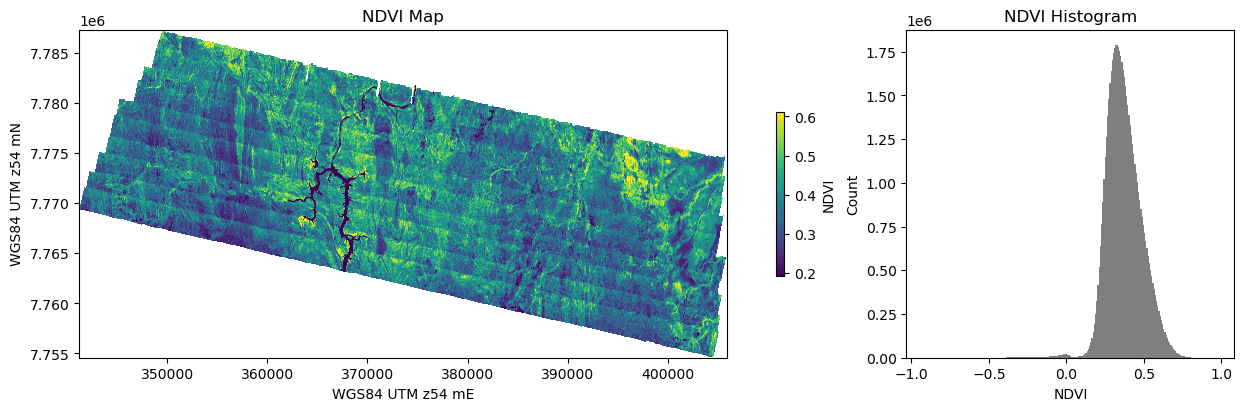

In [5]:
# read the NDVI geotiff into an array, mask the nodata, get raster extents in spatial coordinates
with rasterio.open(ndvi_fn,'r') as src:
  region = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
  ndvi_ar = rasterio.open(ndvi_fn,'r').read(1)
  ndvi_ar[ndvi_ar==-999] = np.nan
  src.close()

# plot the feature
fig = plt.figure(figsize=(15,4), constrained_layout=True)
gs = fig.add_gridspec(nrows=1, ncols=4)
ax0 = fig.add_subplot(gs[0, 0:3])
ax1 = fig.add_subplot(gs[0, 3:4])

# plot the NDVI data scaled to 95%
map = ax0.imshow(ndvi_ar, extent=region, vmin=np.nanpercentile(ndvi_ar,2.5), vmax=np.nanpercentile(ndvi_ar,97.5))
fig.colorbar(map, ax=ax0, shrink=0.5, label='NDVI')
ax0.set(title='NDVI Map', ylabel='WGS84 UTM 54S mN', xlabel='WGS84 UTM 54S mE')

bins = np.linspace(np.nanmin(ndvi_ar), np.nanmax(ndvi_ar), 250)
ax1.hist(ndvi_ar.flatten()[~np.isnan(ndvi_ar.flatten())], color='k', alpha=0.5, bins=bins)
ax1.set(title='NDVI Histogram', ylabel='Count', xlabel='NDVI')
plt.show()

## 3. Generate Vegetation Mask

Use an arbitrary cutoff value to determine what is and isn't vegetated.

In [6]:
# define the cutoff value
cutoff_val = 0.55

# create the mask
veg_ar = ndvi_ar > cutoff_val
veg_ar = veg_ar.astype('int16')
veg_ar[np.isnan(ndvi_ar)] = -999

# define output mask file
veg_fn = r'/storage/gsq_hymap/outputs/GSQ_block-d_mosaic_vegetation_mask.tif'

# write the mask to output using the NDVI map as a template
with rasterio.open(ndvi_fn,'r') as src:
  meta = src.meta.copy()
  meta.update({'dtype':'int16','nodata':-999})
  with rasterio.open(veg_fn,'w',**meta) as dst:
    dst.write(veg_ar,1)
    dst.close()
  src.close()

# convert this to a cloud optimised geotiff
subprocess_to_cog(veg_fn)

0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 14387, 7285
0...10...20...30...40...50...60...70...80...90...100 - done.


Plot both NDVI and vegetation mask data from around Lake Julius. Bit stripey :(

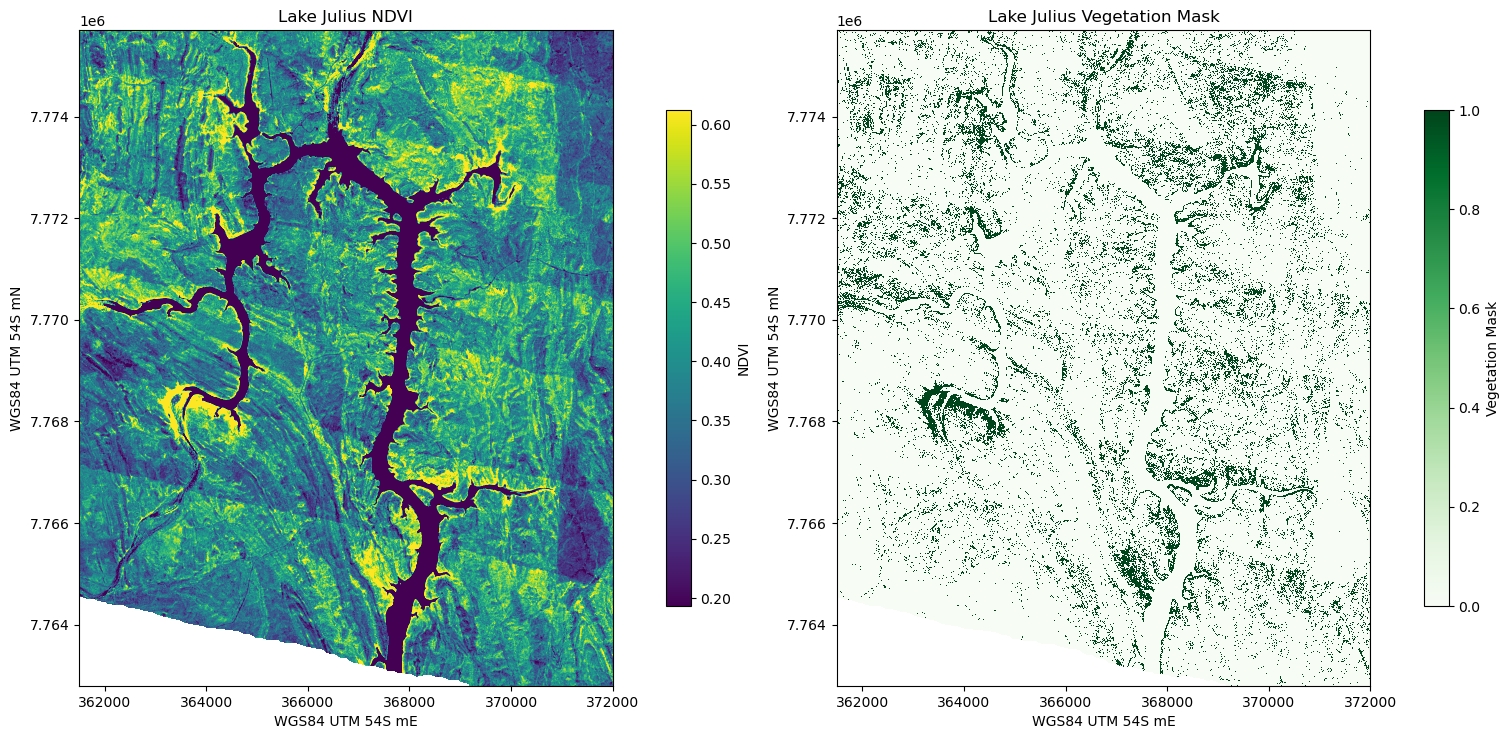

In [7]:
# plot data
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(15,10),constrained_layout=True)

ndvi_plt = ax0.imshow(ndvi_ar, extent=region, vmin=np.nanpercentile(ndvi_ar,2.5), vmax=np.nanpercentile(ndvi_ar,97.5))
veg_plt = ax1.imshow(np.ma.masked_array(veg_ar,np.isnan(ndvi_ar)), extent=region, cmap='Greens', interpolation='nearest')

fig.colorbar(ndvi_plt, ax=ax0, shrink=0.5, label='NDVI')
fig.colorbar(veg_plt, ax=ax1, shrink=0.5, label='Vegetation Mask')

[ax.set(xlim=(361500, 372000), ylim=(7762800, 7775700)) for ax in [ax0,ax1]]
[ax.set(xlabel='WGS84 UTM 54S mE', ylabel='WGS84 UTM 54S mN') for ax in [ax0,ax1]]

ax0.set(title='Lake Julius NDVI')
ax1.set(title='Lake Julius Vegetation Mask')

plt.show()